In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rma
from scipy.interpolate import interp1d

In [2]:
# Constants
c = 3e8  # speed of light in m/s
fc = 3e9  # center frequency in Hz
B = 2e9  # bandwidth in Hz
Rs = 0  # y-coordinate to scene center (downrange)
Za = 0
L = 8 * 0.3048  # aperture length in meters
Xa = np.linspace(-L / 2, L / 2, 48)  # cross-range positions
Ya = Rs
fsteps = 500

In [3]:
# Target parameters
targets = [
    {'a': 1, 'xt': 2 * 0.3048, 'yt': -15 * 0.3048, 'zt': 0}
    # {'a': 1, 'xt': 1 * 0.3048, 'yt': -10 * 0.3048, 'zt': 0},
    # {'a': 1, 'xt': 0 * 0.3048, 'yt': -5 * 0.3048, 'zt': 0},
    # {'a': 1, 'xt': -1 * 0.3048, 'yt': -10 * 0.3048, 'zt': 0},
    # {'a': 1, 'xt': -2 * 0.3048, 'yt': -15 * 0.3048, 'zt': 0}
]

# Compute Kr (rad/m)
Kr = np.linspace((4 * np.pi / c) * (fc - B / 2), (4 * np.pi / c) * (fc + B / 2), fsteps)

# Compute phase for each target
sif = np.zeros((len(Xa), fsteps), dtype=complex)
for target in targets:
    Rb = np.sqrt((Ya - target['yt'])**2 + (Za - target['zt'])**2)
    Rt = np.sqrt((Xa - target['xt'])**2 + Rb**2)
    phi_if = np.outer(Rt - Rs, Kr)
    sif += target['a'] * np.exp(-1j * phi_if)

# Save the data (optional, e.g., using np.save or pickle)
# np.save('thruwall.npy', sif)

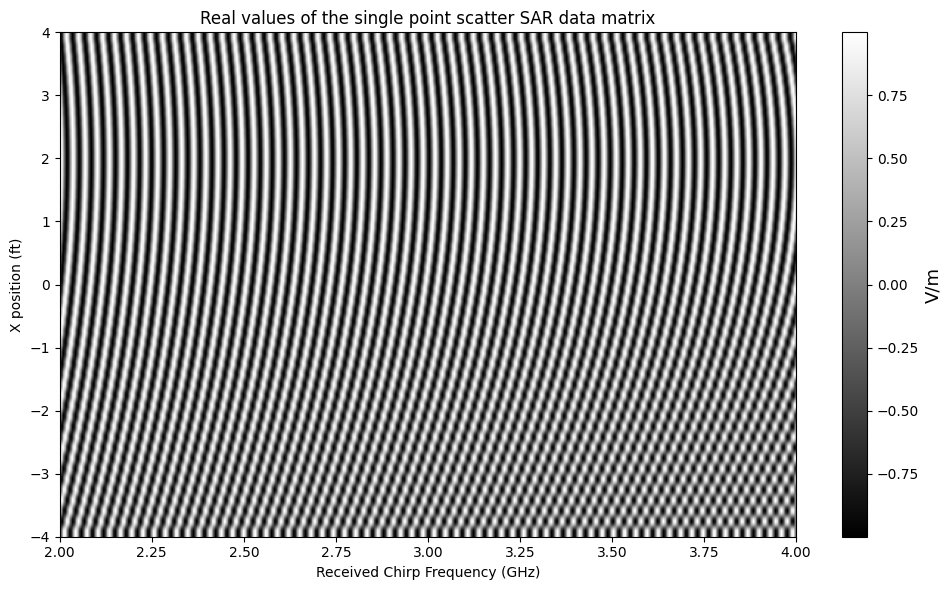

In [4]:
# Plotting the real part of the SAR data matrix
plt.figure(figsize=(10, 6))
extent = [Kr[0] * c / (4 * np.pi * 1e9), Kr[-1] * c / (4 * np.pi * 1e9), Xa[0] / 0.3048, Xa[-1] / 0.3048]
plt.imshow(np.real(sif), extent=extent, aspect='auto', cmap='gray', origin='lower')
plt.xlabel('Received Chirp Frequency (GHz)')
plt.ylabel('X position (ft)')
plt.title('Real values of the single point scatter SAR data matrix')
cbar = plt.colorbar()
cbar.set_label('V/m', fontsize=13)
plt.tight_layout()
plt.savefig('real_value_of_single_pt_scatterer_raw_data.jpg', dpi=100)
plt.show()

In [5]:
# Constants
c = 3e8  # Speed of light (m/s)

# Radar parameters
fc = 3e9  # Center frequency (Hz)
B = 4e9 - 2e9  # Bandwidth (Hz)
cr = 2e9 / 10e-3  # Chirp rate (Hz/s)
Tp = 10e-3  # Pulse width (s)

# Target geometry and aperture
Rs = 0  # Scene center downrange (m)
Za = 0  # Elevation, assumed flat (m)
delta_x = (2 * (1 / 12)) * 0.3048  # 2 inch spacing converted to meters

# You must already have 'sif' defined
L = delta_x * sif.shape[0]  # Aperture length in meters
Xa = np.linspace(-L / 2, L / 2, int(L / delta_x))  # Cross-range radar positions

# Fast time (range time domain)
t = np.linspace(0, Tp, sif.shape[1])  # Time samples during chirp

# Compute Kr (rad/m), the wavenumber space
Kr = np.linspace((4 * np.pi / c) * (fc - B / 2), (4 * np.pi / c) * (fc + B / 2), len(t))

# Ya = Rs (cross-range alignment with scene center)
Ya = Rs

In [6]:
rma = rma.RMA(Kr=Kr, Xa=Xa, delta_x=(Xa[1] - Xa[0]), Rs=Rs)

In [7]:
image_dB, crossrange, downrange = rma.process(sif)

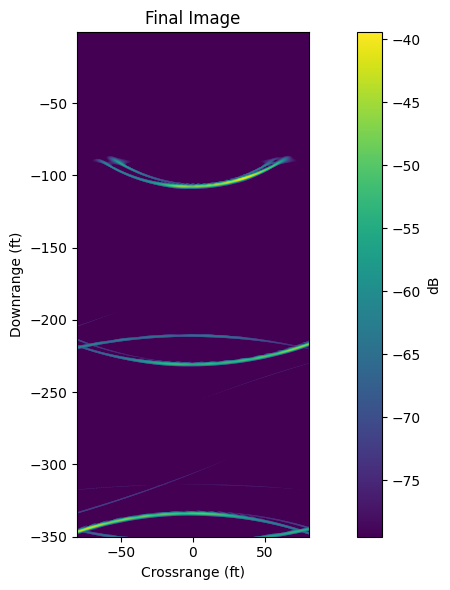

In [8]:
plt.figure(figsize=(10, 6))
plt.imshow(image_dB, cmap='viridis', aspect='equal',
            extent=[crossrange[0], crossrange[-1], downrange[-1], downrange[0]],
            vmin=np.max(image_dB) - 40, vmax=np.max(image_dB))
plt.title('Final Image')
plt.xlabel('Crossrange (ft)')
plt.ylabel('Downrange (ft)')
plt.colorbar(label='dB')
plt.tight_layout()
plt.show()